# mmWave Vital Reconstruction — Processing Pipeline

## Overview
原始 JSON → 提取 x,y,z → 計算 range → 均勻重取樣 (~20 Hz) → 線性去趨勢 →  
分支：呼吸 (0.1–0.5 Hz) 與心跳 (0.8–3.0 Hz) → 峰值檢測 → 速率估計 → 輸出與視覺化

---

## Steps

1. **原始 JSON 資料**
   - 逐檔解析 `data[].frameData`。
   - 讀取 `timestamp`（毫秒）與 `trackData`。

2. **提取 x, y, z 座標**
   - 取第一個有效 track。
   - 取得三維位置 `(x, y, z)`（單位：公尺）。

3. **計算目標距離（range）**
   - \( r(t) = \sqrt{x^2 + y^2 + z^2} \)。

4. **重新取樣成均勻時間序列（~20 Hz）**
   - 由時間戳估計取樣率。
   - 線性插值到均勻時間軸 \( t_u \)。

5. **線性去趨勢**
   - 對 \( r(t_u) \) 執行線性去趨勢，得 \( r_d(t_u) \)。

6. **分支處理**
   - **呼吸帶通濾波**：Butterworth，0.1–0.5 Hz → 得 \( r_{\text{resp}} \)  
     **峰值檢測**：設置最小峰距與顯著性  
     **呼吸率估計**：以相鄰峰間距中位數換算 BPM
   - **心跳帶通濾波**：Butterworth，0.8–3.0 Hz → 得 \( r_{\text{heart}} \)  
     **峰值檢測**：同上（頻帶對應的最小峰距）  
     **心率估計**：以相鄰峰間距中位數換算 BPM

7. **輸出結果**
   - 表格：取樣率、時長、呼吸率 BPM、心率 BPM。
   - CSV：`t_sec, range_detrended, respiration, heartbeat`。
   - 視覺化：呼吸與心跳波形圖。

---

## Notes
- 這是位移導出的替代波形（BCG/PPG-like），非臨床 ECG。
- 品質受姿勢、距離、遮擋與追蹤穩定度影響。
- 若裝置提供相位訊號，可改用相位差提升微位移靈敏度。


Found 2 JSON files:
  - replay_1.json
  - replay_2.json

Loaded 176 valid frames
Time range: 1758706761527 - 1758706779344 ms

Resampled to 11.1 Hz (199 samples)

HEART RATE ESTIMATION RESULTS
Duration: 17.8 seconds
Sampling rate: 11.1 Hz
Estimated Heart Rate: 60.6 beats/min

Saved time series to: outputs\heart_rate_series.csv



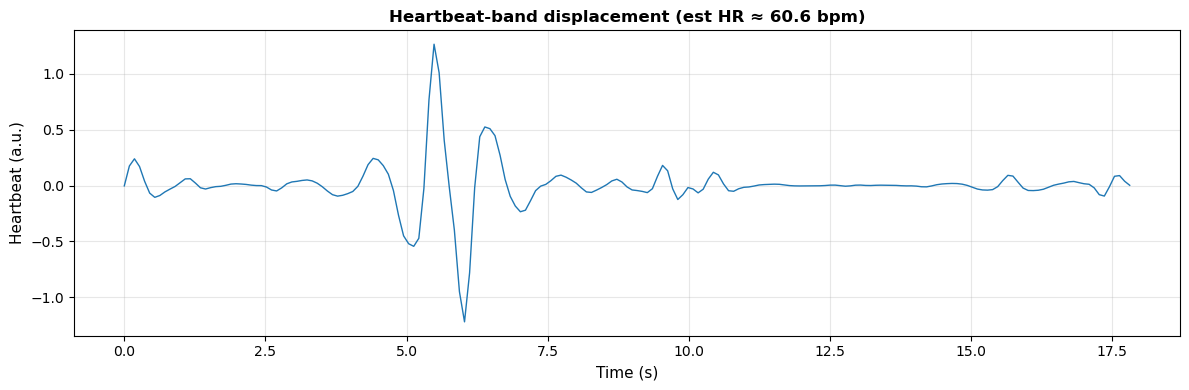

Saved plot to: outputs\heartbeat.png



In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
mmWave heart rate extraction from JSON logs (Notebook Version).

Usage in Jupyter Notebook:
  process_vitals_folder("path/to/json/folder", outdir="outputs")
"""
import os
import json
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, HTML


def load_frames(paths):
    """Load and parse JSON frame data from multiple files."""
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {})
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            track = None
            td = fd.get("trackData", None)
            # Accept common shapes: list-of-lists or list-of-dicts
            if isinstance(td, list) and len(td) > 0:
                if isinstance(td[0], list):
                    track = td[0]
                elif isinstance(td[0], dict):
                    # try common keys
                    cand = td[0]
                    if all(k in cand for k in ("x", "y", "z")):
                        track = [cand["x"], cand["y"], cand["z"]]
                    elif "pos" in cand and isinstance(cand["pos"], list) and len(cand["pos"]) >= 3:
                        track = cand["pos"][:3]

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "track": track,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None)
            })
    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values("timestamp_ms").reset_index(drop=True)
    return df


def extract_xyz(track):
    """Extract x, y, z coordinates from track data."""
    if track is None:
        return (np.nan, np.nan, np.nan)
    if isinstance(track, (list, tuple)) and len(track) >= 3:
        return (float(track[0]), float(track[1]), float(track[2]))
    return (np.nan, np.nan, np.nan)


def bandpass(sig, fs, f1, f2, order=4):
    """Apply Butterworth bandpass filter."""
    ny = 0.5 * fs
    low = max(1e-4, f1 / ny)
    high = min(0.99, f2 / ny)
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, sig)


def estimate_rate(sig, fs, min_bpm, max_bpm):
    """Estimate heart rate from signal."""
    if len(sig) < 10:
        return np.nan
    min_dist = max(1, int(fs * 60.0 / max_bpm))
    prom = np.std(sig) * 0.2
    peaks, _ = signal.find_peaks(sig, distance=min_dist, prominence=prom)
    if len(peaks) < 2:
        return np.nan
    intervals = np.diff(peaks) / fs
    med = np.median(intervals)
    if not np.isfinite(med) or med <= 0:
        return np.nan
    return 60.0 / med


def resample_uniform(t_sec, y, fs_hint=None):
    """Resample signal to uniform time intervals."""
    dt = np.median(np.diff(t_sec))
    if not np.isfinite(dt) or dt <= 0:
        fs = fs_hint if fs_hint else 20.0
    else:
        fs = 1.0 / dt
    fs = float(np.clip(fs, 5.0, 200.0))
    t_uniform = np.arange(t_sec[0], t_sec[-1], 1.0 / fs)
    y_uniform = np.interp(t_uniform, t_sec, y)
    return fs, t_uniform, y_uniform


def plot_series_inline(t, y, title, ylabel):
    """Plot time series inline in notebook."""
    plt.figure(figsize=(12, 4))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def process_vitals_folder(folder_path, outdir="outputs", fs_hint=20.0):
    """
    Process all JSON files in a folder for heart rate extraction.
    
    Parameters:
    -----------
    folder_path : str
        Path to folder containing JSON files
    outdir : str
        Output directory for CSV and PNG files
    fs_hint : float
        Fallback sampling rate if timestamps are irregular
    """
    # Find all JSON files in folder
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    
    if not json_files:
        print(f"[error] No JSON files found in {folder_path}")
        return None
    
    print(f"Found {len(json_files)} JSON files:")
    for f in json_files:
        print(f"  - {os.path.basename(f)}")
    print()
    
    # Load frames
    df = load_frames(json_files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    # Extract xyz and range
    xyz = np.array([extract_xyz(tr) for tr in df["track"]], dtype=float)
    df["x"], df["y"], df["z"] = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    df["range_m"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
    df2 = df.dropna(subset=["range_m", "timestamp_ms"])
    
    if df2.empty:
        print("[error] No valid trackData with xyz found.")
        return None

    print(f"Loaded {len(df2)} valid frames")
    print(f"Time range: {df2['timestamp_ms'].iloc[0]:.0f} - {df2['timestamp_ms'].iloc[-1]:.0f} ms")
    print()

    # Time axis in seconds
    t = (df2["timestamp_ms"].to_numpy() - df2["timestamp_ms"].iloc[0]) / 1000.0
    r = df2["range_m"].to_numpy()

    # Uniform resample for stable filtering
    fs, t_uni, r_uni = resample_uniform(t, r, fs_hint=fs_hint)
    print(f"Resampled to {fs:.1f} Hz ({len(t_uni)} samples)")
    
    # Detrend
    r_detr = signal.detrend(r_uni, type="linear")

    # Heart rate bandpass filter: 0.8-3.0 Hz (48-180 bpm)
    heart = bandpass(r_detr, fs, 0.8, 3.0)

    # Heart rate estimate
    hr_bpm = estimate_rate(heart, fs, 40, 180)

    # Display results
    print("\n" + "="*60)
    print("HEART RATE ESTIMATION RESULTS")
    print("="*60)
    print(f"Duration: {t_uni[-1] - t_uni[0]:.1f} seconds")
    print(f"Sampling rate: {fs:.1f} Hz")
    
    if np.isfinite(hr_bpm):
        print(f"Estimated Heart Rate: {hr_bpm:.1f} beats/min")
    else:
        print("Estimated Heart Rate: Unable to estimate")
    print("="*60 + "\n")

    # Save CSV
    os.makedirs(outdir, exist_ok=True)
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "range_detrended": r_detr,
        "heartbeat": heart
    })
    result_df.to_csv(csv_path, index=False)
    print(f"Saved time series to: {csv_path}\n")

    # Plot heartbeat
    heart_title = f"Heartbeat-band displacement (est HR ≈ {hr_bpm:.1f} bpm)" if np.isfinite(hr_bpm) else "Heartbeat-band displacement"
    plot_series_inline(t_uni, heart, heart_title, "Heartbeat (a.u.)")

    # Save PNG file
    plt.figure(figsize=(12, 4))
    plt.plot(t_uni, heart, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Heartbeat (a.u.)")
    plt.title(heart_title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    heart_png = os.path.join(outdir, "heartbeat.png")
    plt.savefig(heart_png, dpi=200)
    plt.close()

    print(f"Saved plot to: {heart_png}\n")

    # Return summary
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]),
        "fs_Hz": float(fs),
        "est_hr_bpm": float(hr_bpm) if np.isfinite(hr_bpm) else None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df
    }
    
    return summary


# Example usage:
summary = process_vitals_folder(r"E:\重要文件\毫米波\實驗區\data\09_24_2025_18_02_45", outdir="outputs")
# 
# Or if you want to access the data:
# df = summary['dataframe']
# print(df.head())
# print(f"Heart Rate: {summary['est_hr_bpm']} bpm")

Spectrum Analysis
Signal length: 286 samples
Duration: 25.6 sec
Sampling rate: 11.1 Hz

📊 1. Computing frequency spectrum (FFT)...
   Dominant frequency: 65.3 bpm (1.089 Hz)
   Difference vs. peak detection: 18.1 bpm

✅ Saved spectrum plot: outputs\/spectrum.png


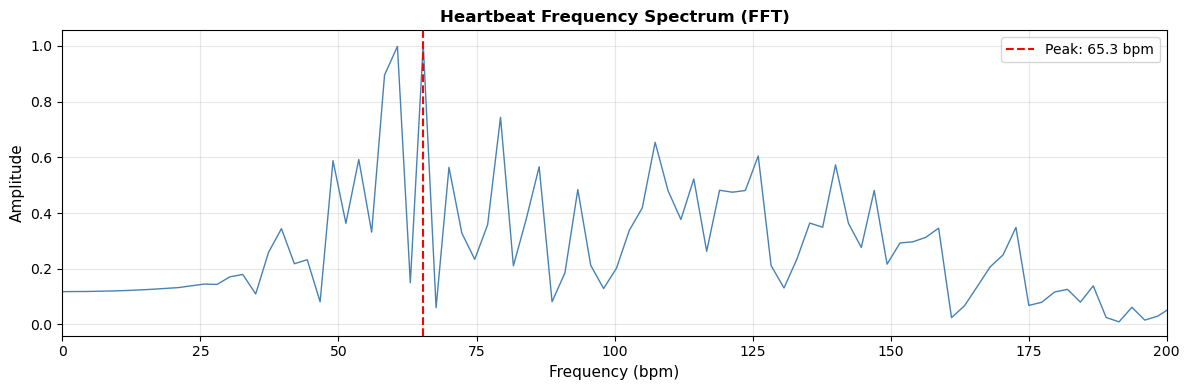


🔥 2. Computing spectrogram...
   Time resolution: 5.66 sec
   Frequency resolution: 9.40 bpm

✅ Saved spectrogram plot: outputs\/spectrogram.png


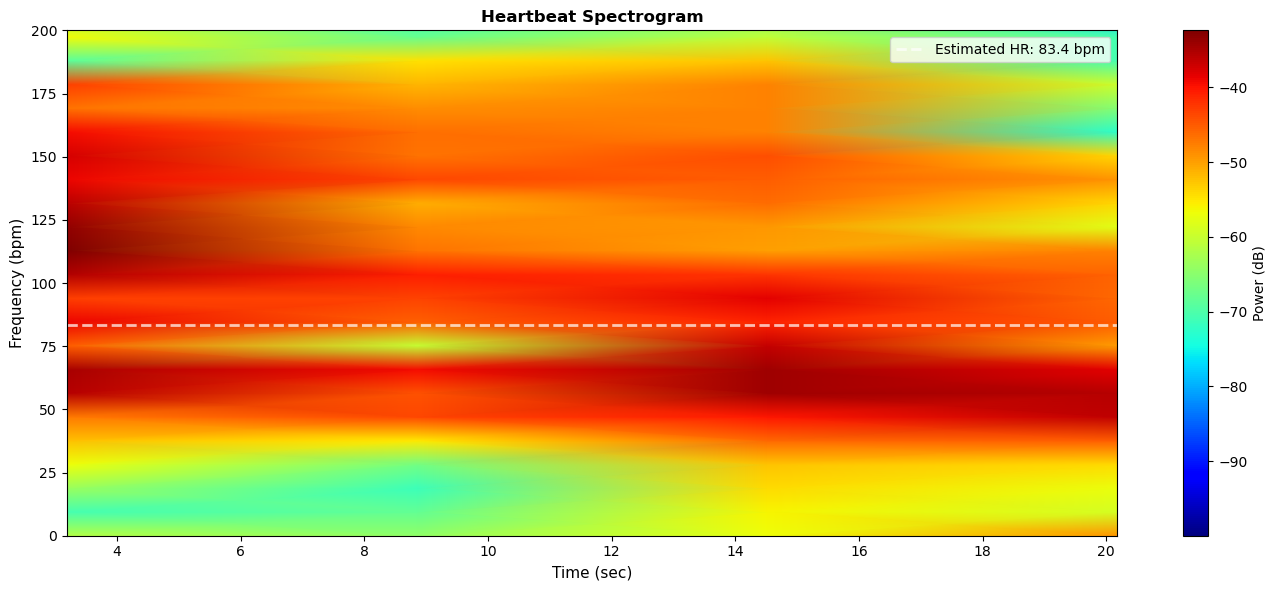


📈 3. Frequency band energy distribution...
   Very Low (<40 bpm)  : ██                                                   4.4%
   Low (40-60 bpm)     : ████████                                            17.1%
   Normal (60-100 bpm) : ██████████████████                                  37.5%
   High (100-120 bpm)  : ███████                                             15.8%
   Very High (>120 bpm): ████████████                                        25.2%

✅ Saved energy distribution plot: outputs\/energy_distribution.png


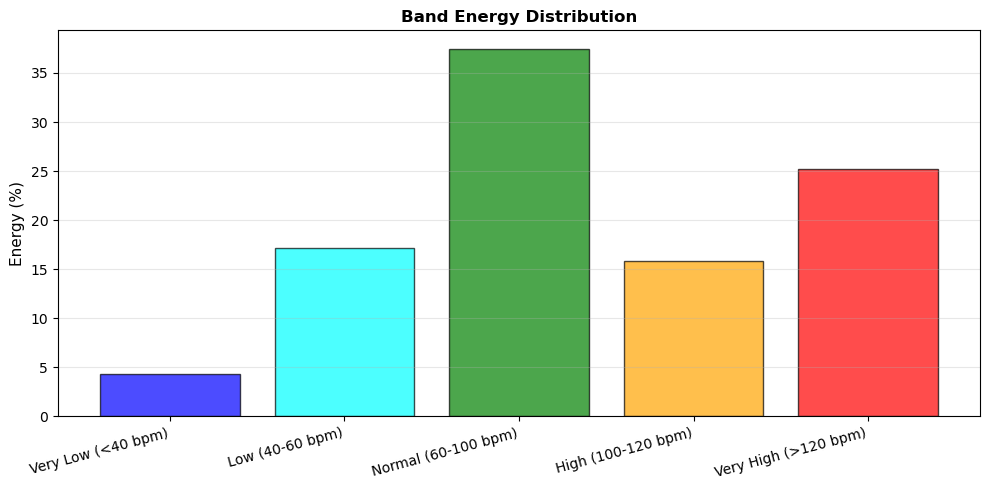


Analysis Complete!


In [21]:
"""
Spectrum Analysis Block - Run in another Notebook cell

Usage:
1. First run the main processing to get summary
2. Then run this block to perform spectrum analysis

Example:
    summary = process_vitals_folder("data/json_logs")
    # Then run the analysis below
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def analyze_spectrum(summary, save_plots=True, outdir=None):
    """
    Perform spectral analysis on processed heartbeat data
    
    Parameters:
    -----------
    summary : dict
        The result dictionary returned from process_vitals_folder()
    save_plots : bool
        Whether to save plots as PNG files
    outdir : str
        Directory for saving plots (default: same as main output)
    
    Returns:
    --------
    dict : dictionary containing spectrum analysis results
    """
    # Get data
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    heartbeat = df['heartbeat'].values
    fs = summary['fs_Hz']
    
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')
    
    print("="*60)
    print("Spectrum Analysis")
    print("="*60)
    print(f"Signal length: {len(heartbeat)} samples")
    print(f"Duration: {t_sec[-1] - t_sec[0]:.1f} sec")
    print(f"Sampling rate: {fs:.1f} Hz")
    print()
    
    # ==================== 1. FFT Spectrum ====================
    print("📊 1. Computing frequency spectrum (FFT)...")
    
    n = len(heartbeat)
    freq = np.fft.rfftfreq(n, 1/fs)  # frequency axis (Hz)
    fft_vals = np.abs(np.fft.rfft(heartbeat))
    freq_bpm = freq * 60  # convert Hz to bpm
    
    # Find dominant frequency
    idx_max = np.argmax(fft_vals[1:]) + 1
    dominant_freq_hz = freq[idx_max]
    dominant_freq_bpm = freq_bpm[idx_max]
    
    print(f"   Dominant frequency: {dominant_freq_bpm:.1f} bpm ({dominant_freq_hz:.3f} Hz)")
    print(f"   Difference vs. peak detection: {abs(dominant_freq_bpm - summary.get('est_hr_bpm', 0)):.1f} bpm")
    print()
    
    # Plot spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(freq_bpm, fft_vals, linewidth=1, color='steelblue')
    plt.axvline(dominant_freq_bpm, color='red', linestyle='--', 
                label=f'Peak: {dominant_freq_bpm:.1f} bpm')
    plt.xlabel("Frequency (bpm)", fontsize=11)
    plt.ylabel("Amplitude", fontsize=11)
    plt.title("Heartbeat Frequency Spectrum (FFT)", fontsize=12, fontweight='bold')
    plt.xlim([0, 200])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_plots:
        spectrum_path = f"{outdir}/spectrum.png"
        plt.savefig(spectrum_path, dpi=200)
        print(f"✅ Saved spectrum plot: {spectrum_path}")
    plt.show()
    
    # ==================== 2. Spectrogram ====================
    print("\n🔥 2. Computing spectrogram...")
    
    nperseg = min(256, len(heartbeat)//4)
    f, t_spec, Sxx = signal.spectrogram(heartbeat, fs, nperseg=nperseg)
    f_bpm = f * 60
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    
    print(f"   Time resolution: {t_spec[1] - t_spec[0]:.2f} sec")
    print(f"   Frequency resolution: {(f_bpm[1] - f_bpm[0]):.2f} bpm")
    print()
    
    plt.figure(figsize=(14, 6))
    im = plt.pcolormesh(t_spec, f_bpm, Sxx_db, shading='gouraud', cmap='jet')
    cbar = plt.colorbar(im, label='Power (dB)')
    plt.ylabel('Frequency (bpm)', fontsize=11)
    plt.xlabel('Time (sec)', fontsize=11)
    plt.title('Heartbeat Spectrogram', fontsize=12, fontweight='bold')
    plt.ylim([0, 200])
    
    if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
        plt.axhline(summary['est_hr_bpm'], color='white', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Estimated HR: {summary['est_hr_bpm']:.1f} bpm")
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_plots:
        spectrogram_path = f"{outdir}/spectrogram.png"
        plt.savefig(spectrogram_path, dpi=200)
        print(f"✅ Saved spectrogram plot: {spectrogram_path}")
    plt.show()
    
    # ==================== 3. Band Energy Distribution ====================
    print("\n📈 3. Frequency band energy distribution...")
    
    bands = {
        "Very Low (<40 bpm)": (0, 40),
        "Low (40-60 bpm)": (40, 60),
        "Normal (60-100 bpm)": (60, 100),
        "High (100-120 bpm)": (100, 120),
        "Very High (>120 bpm)": (120, 200)
    }
    
    band_energy = {}
    for band_name, (low, high) in bands.items():
        mask = (freq_bpm >= low) & (freq_bpm < high)
        energy = np.sum(fft_vals[mask]**2)
        band_energy[band_name] = energy
    
    total_energy = sum(band_energy.values())
    band_percentage = {k: (v/total_energy)*100 for k, v in band_energy.items()}
    
    for band_name, percentage in band_percentage.items():
        bar = "█" * int(percentage / 2)
        print(f"   {band_name:20s}: {bar:50s} {percentage:5.1f}%")
    print()
    
    plt.figure(figsize=(10, 5))
    colors = ['blue', 'cyan', 'green', 'orange', 'red']
    plt.bar(band_percentage.keys(), band_percentage.values(), 
            color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Energy (%)', fontsize=11)
    plt.title('Band Energy Distribution', fontsize=12, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    if save_plots:
        energy_path = f"{outdir}/energy_distribution.png"
        plt.savefig(energy_path, dpi=200)
        print(f"✅ Saved energy distribution plot: {energy_path}")
    plt.show()
    
    # ==================== Return ====================
    results = {
        "dominant_freq_bpm": float(dominant_freq_bpm),
        "dominant_freq_hz": float(dominant_freq_hz),
        "freq_bpm": freq_bpm,
        "fft_amplitude": fft_vals,
        "spectrogram_time": t_spec,
        "spectrogram_freq": f_bpm,
        "spectrogram_power": Sxx_db,
        "band_energy_percentage": band_percentage
    }
    
    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)
    
    return results


# ==================== 使用範例 ====================
# 在主程式執行後，使用此函數進行頻譜分析:
#
# summary = process_vitals_folder("data/json_logs")
spectrum_results = analyze_spectrum(summary, save_plots=True)
#
# # 存取頻譜資料
# print(f"主要頻率: {spectrum_results['dominant_freq_bpm']:.1f} bpm")
# print(f"正常心率能量佔比: {spectrum_results['band_energy_percentage']['正常 (60-100 bpm)']:.1f}%")